In [1]:
%matplotlib inline

import os
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# matplotlib.style.use('ggplot')

plt.rcParams["figure.figsize"] = (16, 9)

print 'Fetching important packages'

Fetching important packages


In [2]:
data_dir = '../data'

def strtodate(s):
    try:
        return datetime.strptime(s, '%d/%m/%Y')
    except ValueError as e:
        pass # let it pass

    try:
        return datetime.strptime(s, '%Y-%m-%d')
    except ValueError as e:
        raise

epoch = datetime.utcfromtimestamp(0)

print 'Get something set up'

Get something set up


In [3]:
train_csvpath = os.path.join(data_dir, 'train_merged.csv')
train_data = pd.read_csv(train_csvpath,
    dtype={
        'Store': int,
        'DayOfWeek': int,
        'Sales': float,
        'Customers': int,
        'Open': int,
        'Promo': int,
        'StateHoliday': str,
        'SchoolHoliday': int,
        'StateHoliday_0': bool,
        'StateHoliday_a': bool,
        'StateHoliday_b': bool,
        'StateHoliday_c': bool,
        'Weekends': bool,
        'Weekdays': bool,
        'StoreType_a': bool,
        'StoreType_b': bool,
        'StoreType_c': bool,
        'StoreType_d': bool,
        'Assortment_a': bool,
        'Assortment_b': bool,
        'Assortment_c': bool,
        'HasCompetition': bool,
        'CompetitionDistance': float,
        'IsDoingPromo2': bool
    },
    parse_dates=['Date'],
    date_parser=strtodate)

train_data.sort_values(['Date', 'Store'],
    axis=0,
    inplace=True,
    ascending=True)

print '\'train.csv\' loaded into pandas'

'train.csv' loaded into pandas


In [4]:
def get_sma(arr, n=30):
    sz  = arr.size

    # Not the best method
    SMA = np.cumsum(arr, axis=None, dtype=float)

    for i in range(min(n, sz)):
        SMA[i] /= (i + 1)

    for i in range(n, sz):
        SMA[i] = SMA[i - 1] + (arr.item(i) - arr.item(i - n)) / n

    return SMA

print 'get_sma() is used to calculate Simple Moving Average'

get_sma() is used to calculate Simple Moving Average


In [5]:
print train_data.columns

Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday', u'StateHoliday_0',
       u'StateHoliday_a', u'StateHoliday_b', u'StateHoliday_c', u'Weekends',
       u'Weekdays', u'StoreType_a', u'StoreType_b', u'StoreType_c',
       u'StoreType_d', u'Assortment_a', u'Assortment_b', u'Assortment_c',
       u'HasCompetition', u'CompetitionDistance', u'IsDoingPromo2'],
      dtype='object')


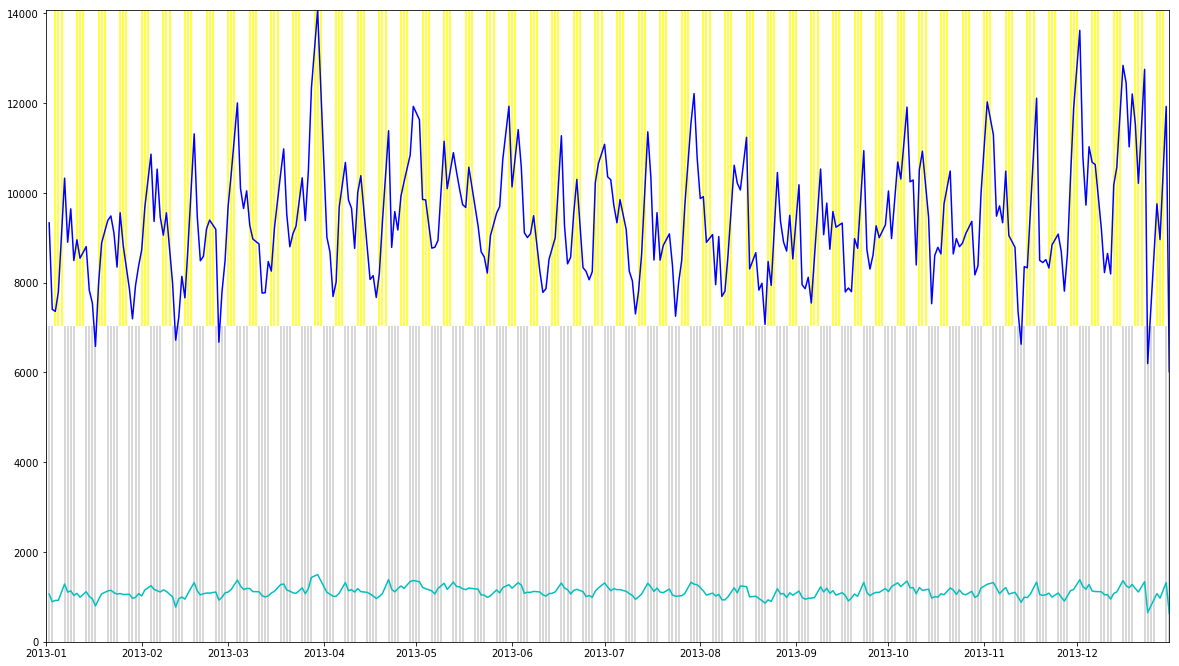

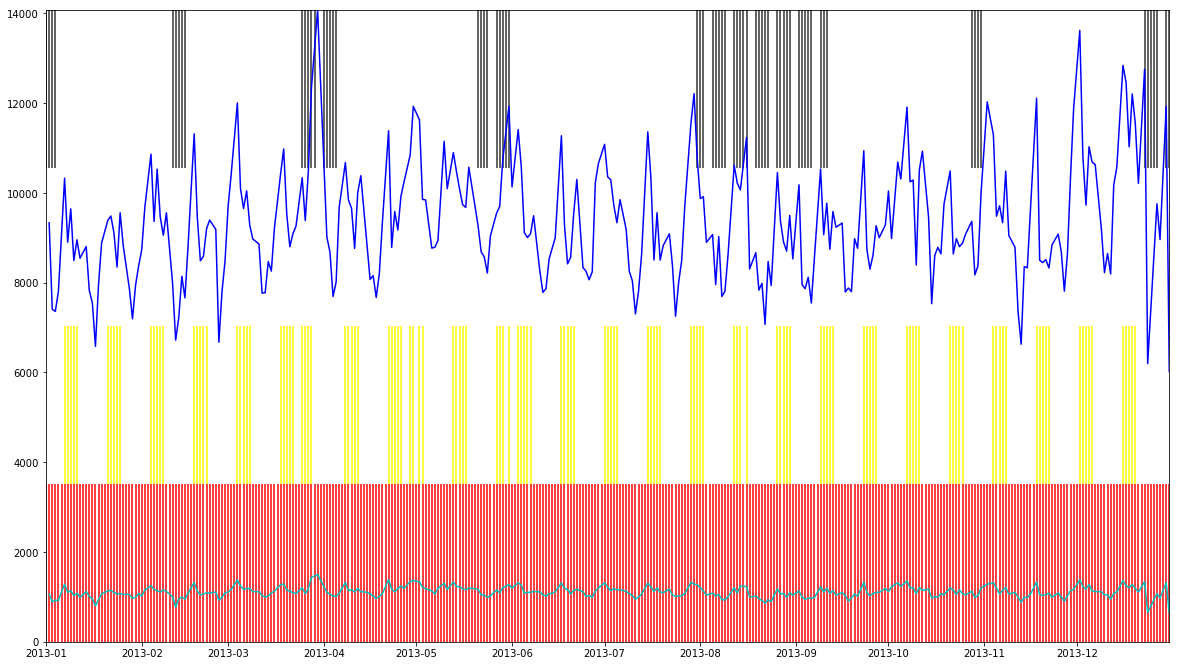

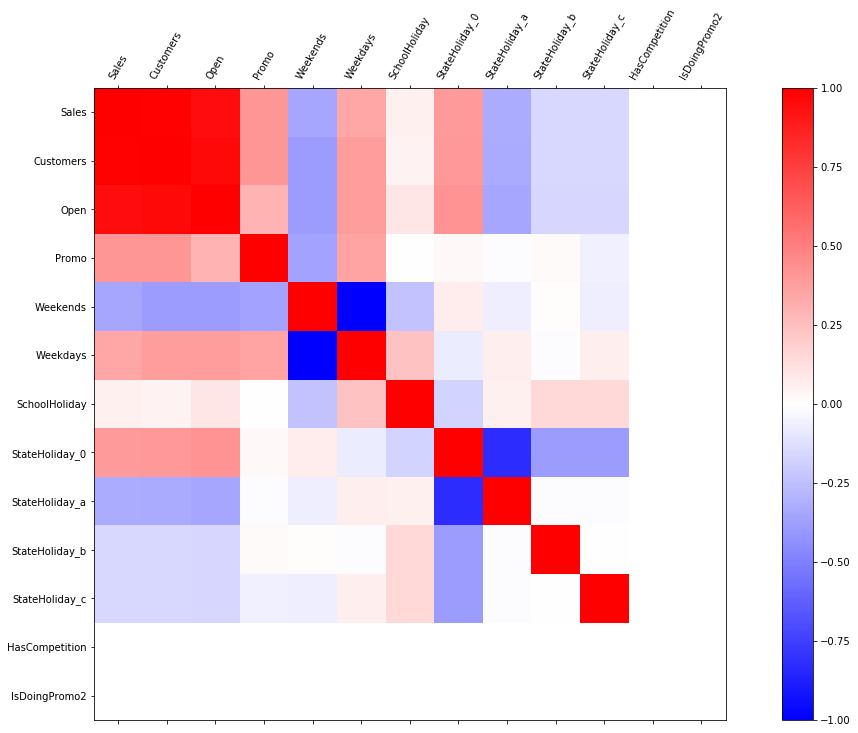

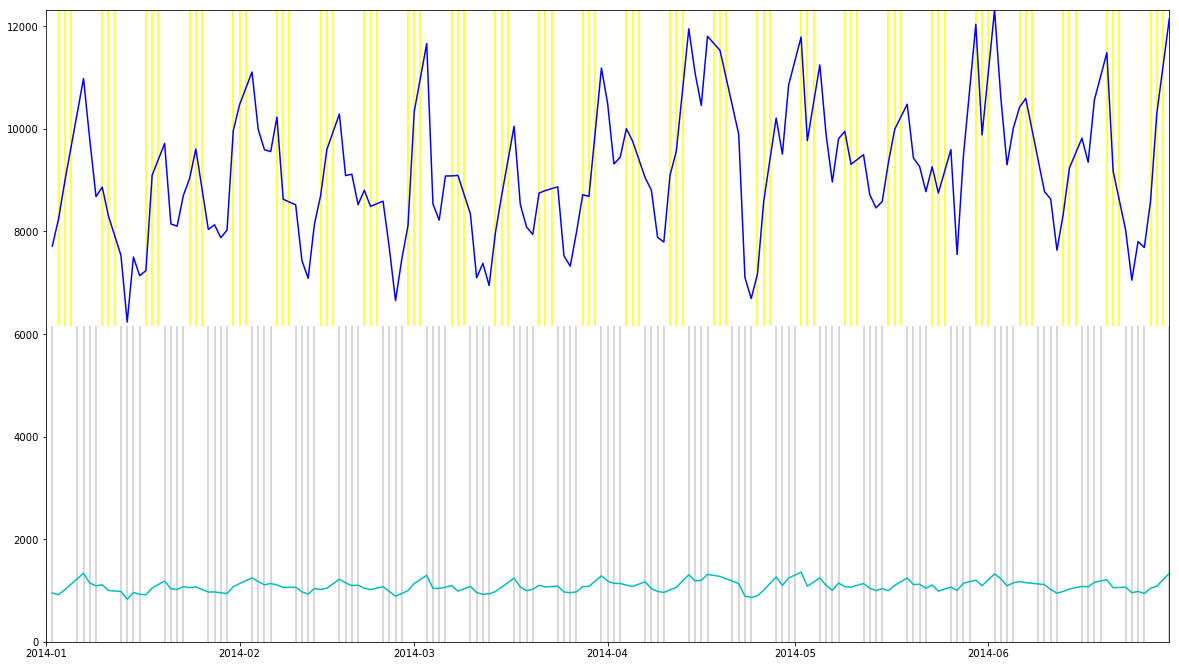

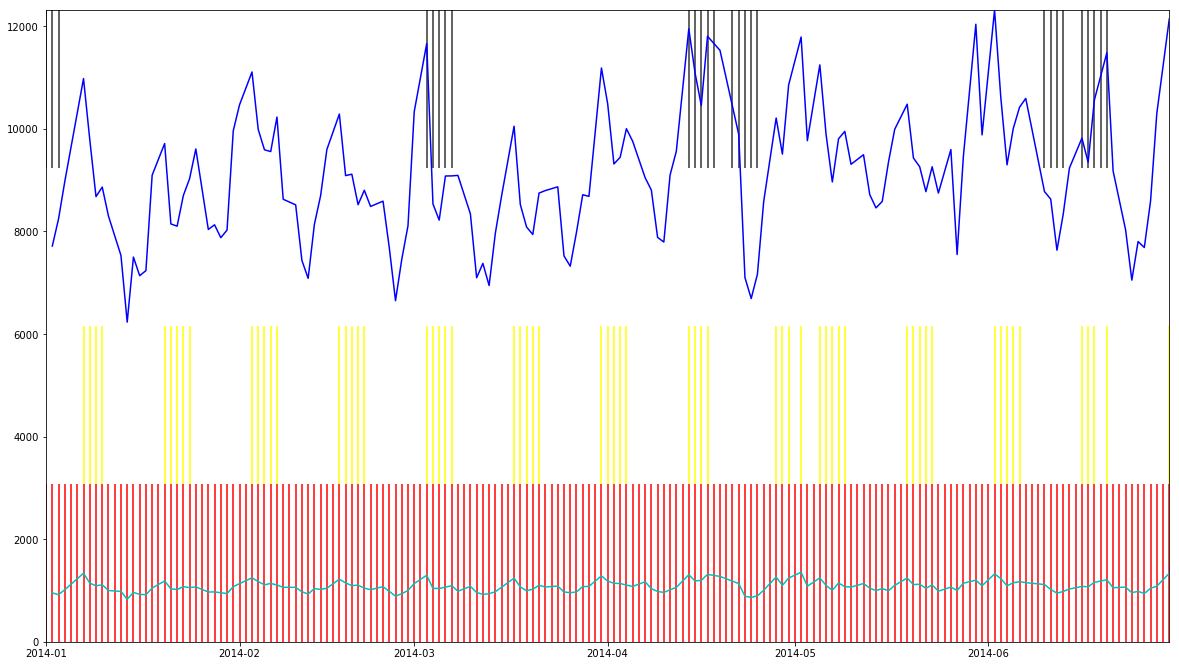

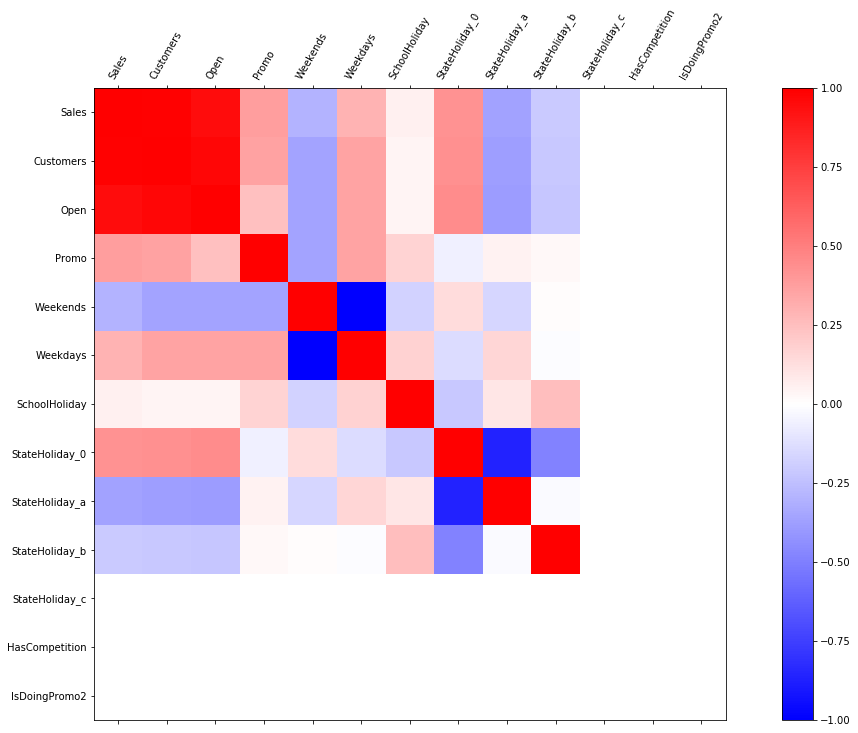

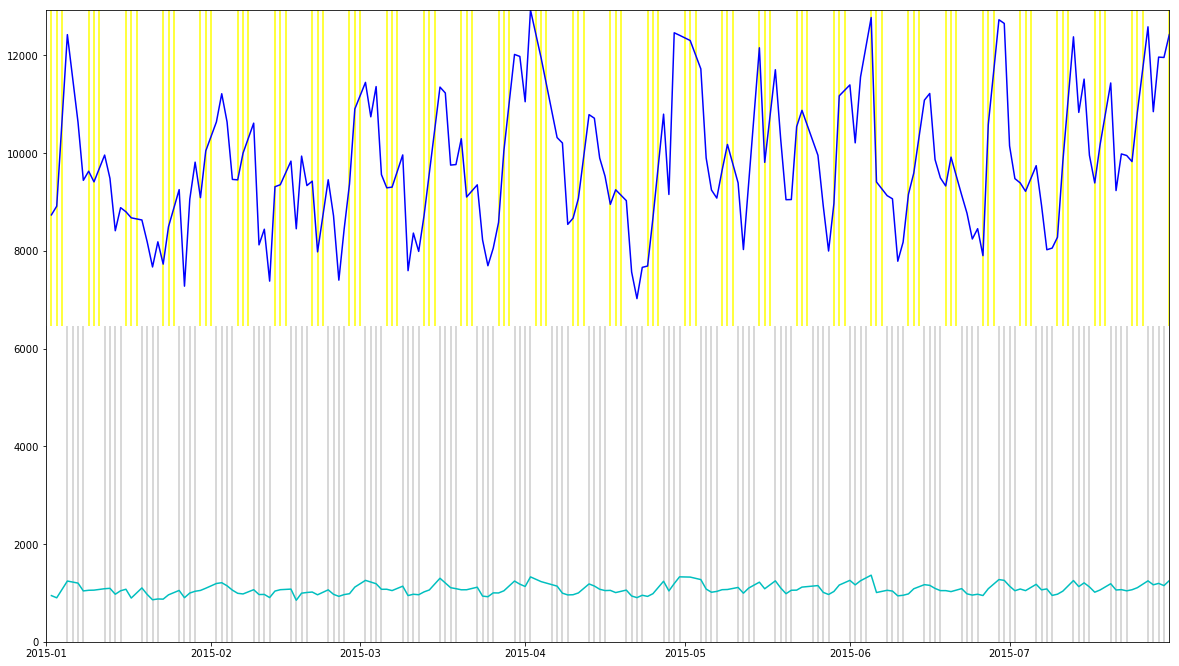

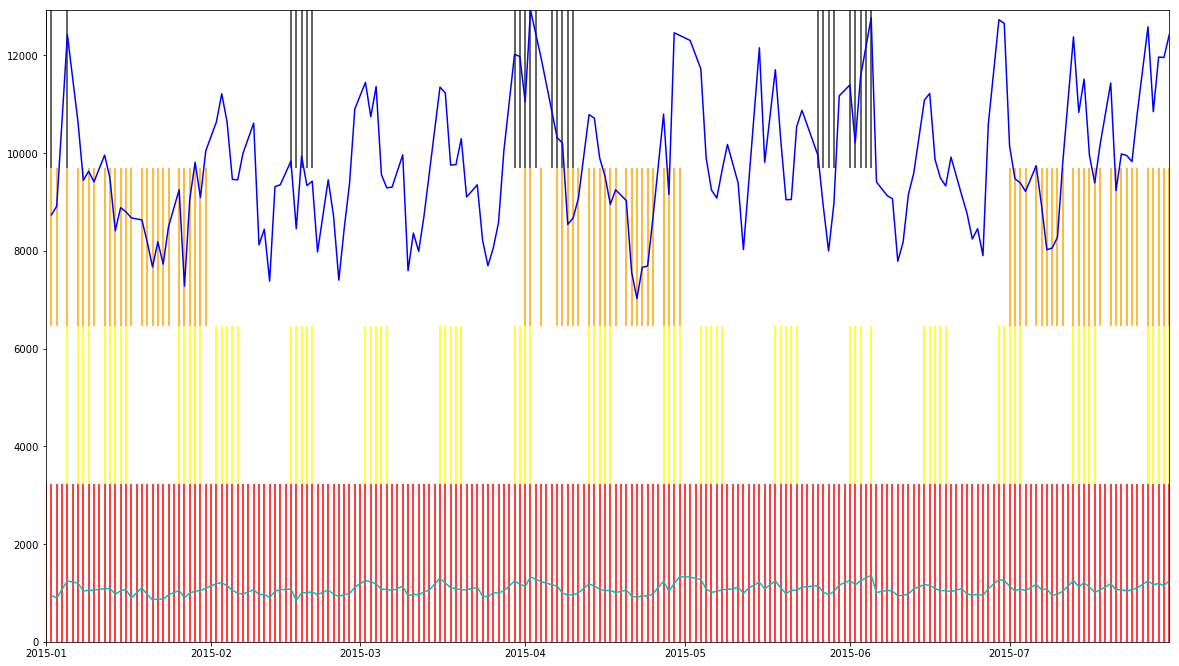

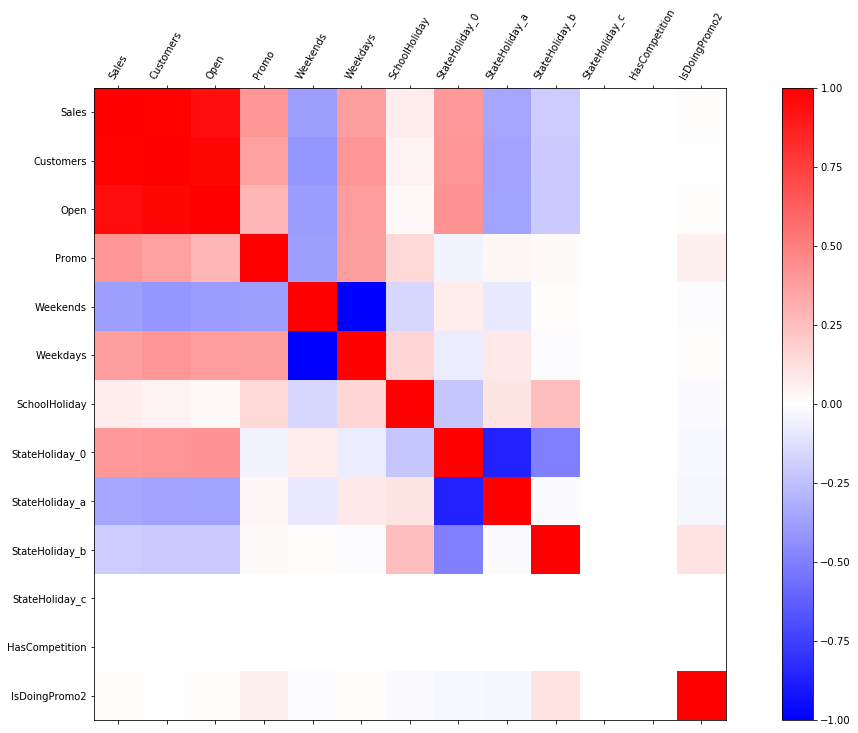

In [7]:
num_stores = 1115
for i in range(36, 37):
    filtered_all = train_data.loc[train_data['Store'] == i,
        ['DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
        'Promo', 'StateHoliday', 'SchoolHoliday', 'Weekends', 'Weekdays',
        'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
        'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
        'Assortment_a', 'Assortment_b', 'Assortment_c', 'HasCompetition', 'CompetitionDistance', 'IsDoingPromo2']]

    filtered_open = train_data.loc[(train_data['Store'] == i) &
        (train_data['Open'] == 1), ['DayOfWeek', 'Date', 'Sales', 'Customers',
        'Promo', 'StateHoliday', 'SchoolHoliday', 'Weekends', 'Weekdays',
        'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
        'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
        'Assortment_a', 'Assortment_b', 'Assortment_c', 'HasCompetition', 'CompetitionDistance', 'IsDoingPromo2']]

    for j in range(0, 3):
        year = 2013 + j

        filtered_all_yrly = filtered_all.loc[filtered_all['Date'].dt.year == year]
        filtered_open_yrly = filtered_open.loc[filtered_open['Date'].dt.year == year]
        
        impt_feats_all = filtered_all_yrly[['Sales', 'Customers',
            'Open', 'Promo', 'Weekends', 'Weekdays', 'SchoolHoliday',
            'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
            'HasCompetition', 'IsDoingPromo2']]

        corrmat_labls = list(impt_feats_all)
        corrmat = impt_feats_all.corr()

        dates_all = filtered_all_yrly['Date'].as_matrix()
        dates_open = filtered_open_yrly['Date'].as_matrix()
        dates_promo = filtered_open_yrly.loc[filtered_open_yrly['Promo'] == 1, 'Date'].as_matrix()
        dates_sch = filtered_all_yrly.loc[filtered_all_yrly['SchoolHoliday'] == 1, 'Date'].as_matrix()
        # Extras
        dates_promo2 = filtered_open_yrly.loc[filtered_open_yrly['IsDoingPromo2'] == True, 'Date'].as_matrix()
        dates_hascp = filtered_all_yrly.loc[filtered_all_yrly['HasCompetition'] == True, 'Date'].as_matrix()
        
        wkdays = filtered_all_yrly.loc[filtered_all_yrly['Weekdays'] == 1, 'Date'].as_matrix()
        wkends = filtered_all_yrly.loc[filtered_all_yrly['Weekends'] == 1, 'Date'].as_matrix()

        promos_open = filtered_open_yrly['Promo'].as_matrix()
        sales_open = filtered_open_yrly['Sales'].as_matrix()
        customers_open = filtered_open_yrly['Customers'].as_matrix()
        SMA7 = get_sma(sales_open, n=7)
        SMA21 = get_sma(sales_open, n=21)

        y_min = 0
        y_max = sales_open.max()
        y_max1 = y_max / 4.
        y_max2 = y_max / 2.
        y_max3 = y_max / 4. * 3.

        plt.figure(1)
        plt.subplot(1, 1, 1)
        plt.vlines(wkdays, 0., y_max/2., color='#cccccc', zorder=-1)
        plt.vlines(wkends, y_max/2., y_max, color='yellow', zorder=0)
        plt.plot(dates_open, sales_open, '-b', zorder=1)
#         plt.plot(dates_open, SMA21, '-r', zorder=2)
#         plt.plot(dates_open, SMA7, '-g', zorder=3)
        plt.plot(dates_open, customers_open, '-c', zorder=4)
        plt.xlim((dates_all[0], dates_all[-1]))
        plt.ylim((y_min, y_max))
        plt.subplots_adjust(left=0.025, bottom=0., right=1., top=0.975, wspace=0., hspace=0.)
        
        plt.figure(2)
        plt.subplot(1, 1, 1)
        plt.vlines(dates_hascp, y_min, y_max1, color='red', zorder=-3)
        plt.vlines(dates_promo, y_max1, y_max2, color='yellow', zorder=-2)
        plt.vlines(dates_promo2, y_max2, y_max3, color='#ffa500', zorder=-1)
        plt.vlines(dates_sch, y_max3, y_max, color='#333333', zorder=0)
        plt.plot(dates_open, sales_open, '-b', zorder=3)
        plt.plot(dates_open, customers_open, '-c', zorder=4)
        plt.xlim((dates_all[0], dates_all[-1]))
        plt.ylim((y_min, y_max))
        plt.subplots_adjust(left=0.025, bottom=0., right=1., top=0.975, wspace=0., hspace=0.)
        
        fig = plt.figure(3)
        ax  = fig.add_subplot(1, 1, 1)
        cax = ax.matshow(corrmat, cmap='bwr', vmin=-1., vmax=1.)
        plt.xticks(range(len(corrmat_labls)), corrmat_labls, rotation=60)
        plt.yticks(range(len(corrmat_labls)), corrmat_labls)
        fig.colorbar(cax, orientation='vertical')
        plt.subplots_adjust(left=0.025, bottom=0., right=1., top=0.975, wspace=0., hspace=0.)
        plt.show()
